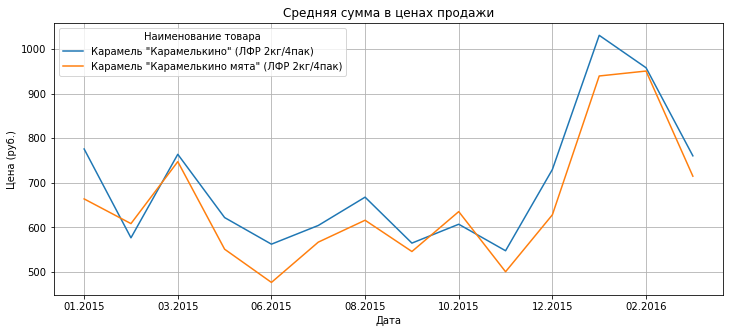

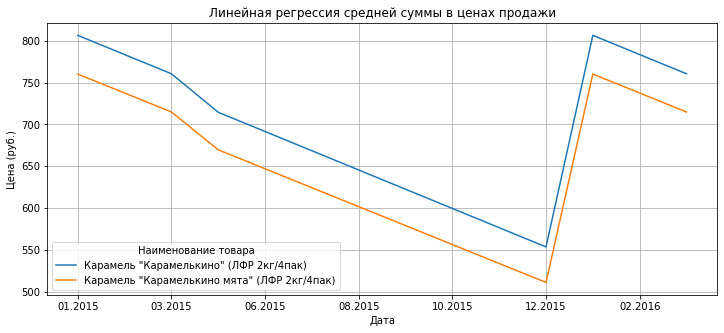

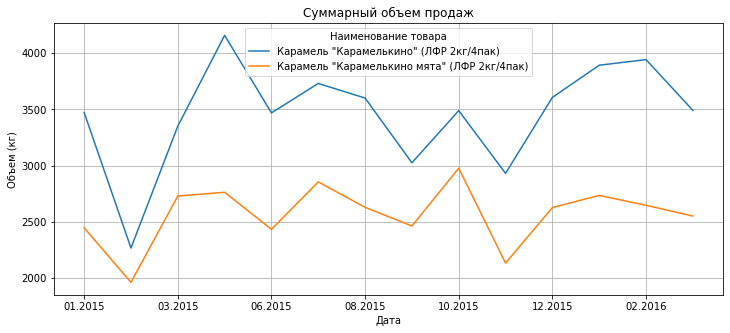

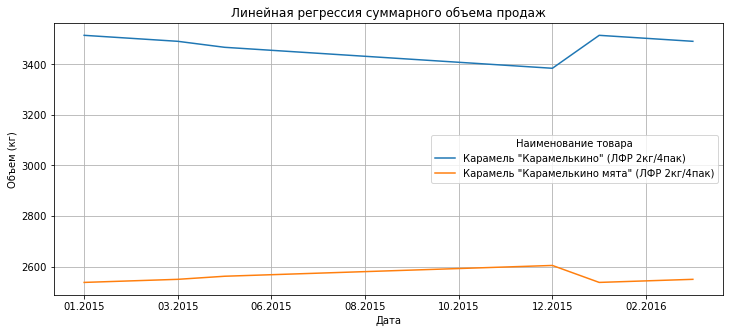

In [375]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# ====================================================== FUNC ======================================================
# Show graph of the dataframe and save it to files
def show_plot(df, title='Graph', xlabel='x', ylabel='y', fname='graph'):
    fig, ax = plt.subplots()
    dates = map(lambda date: dt.datetime(date[0], date[1], 1).strftime('%m.%Y'), df.index.to_flat_index().values)
    df.set_axis(dates, inplace=True)
    df.plot(ax=ax, figsize=(12, 5), title=title, grid=True, xlabel=xlabel, ylabel=ylabel)
    fig.savefig(f'{fname}.png')
    fig.savefig(f'{fname}.jpg')

# ====================================================== CONST =====================================================
product_names = ['Карамель "Карамелькино" (ЛФР 2кг/4пак)', 'Карамель "Карамелькино мята" (ЛФР 2кг/4пак)']
train_years = [2015, 2016]
calculate_year = 2016

# ====================================================== MAIN ======================================================
# Load data
df = pd.read_excel('./input.xlsx')

# Make pivot tables
df_prices = df.pivot_table('Сумма в ценах продажи', index=['Год', 'Месяц'], columns='Наименование товара', aggfunc=np.mean)
df_volume = df.pivot_table('Продажи в кг', index=['Год', 'Месяц'], columns='Наименование товара', aggfunc=np.sum)

# Drop products that will not be used for graphs/calculations
df_prices = df_prices[product_names]
df_volume = df_volume[product_names]

# ======= Calculate next month of the year =======
# Create model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Initialize arrays
x_train = np.array(list(map(lambda data: data[1], df_prices.index.to_flat_index().values))).reshape(-1, 1)
x_predict = np.append(x_train, [x_train[len(x_train) - 1] + 1], axis=0)
prices_y_predicts = np.empty((0, len(x_predict)))
prices_next_month_predicts = np.empty(0)
volume_y_predicts = np.empty((0, len(x_predict)))
volume_next_month_predicts = np.empty(0)

# Make predictions for every product we only need
for product_name in product_names:
    # Prices prediction
    prices_y_train = df_prices[product_name].values
    model.fit(x_train, prices_y_train)
    prices_y_predict = model.predict(x_predict)
    prices_y_predicts = np.append(prices_y_predicts, [prices_y_predict], axis=0)
    prices_next_month_predicts = np.append(prices_next_month_predicts, prices_y_predict[len(prices_y_predict) - 1])
    # Volume prediction
    volume_y_train = df_volume[product_name].values
    model.fit(x_train, volume_y_train)
    volume_y_predict = model.predict(x_predict)
    volume_y_predicts = np.append(volume_y_predicts, [volume_y_predict], axis=0)
    volume_next_month_predicts = np.append(volume_next_month_predicts, volume_y_predict[len(volume_y_predict) - 1])

# Create index for next month
next_month_idx = pd.MultiIndex.from_arrays([[calculate_year], [x_predict.flatten()[len(x_predict) - 1]]], names=['Год', 'Месяц'])

# Append dataframes with new predictions
df_prices = df_prices.append(pd.DataFrame([prices_next_month_predicts], index=next_month_idx, columns=df_prices.columns))
df_volume = df_volume.append(pd.DataFrame([volume_next_month_predicts], index=next_month_idx, columns=df_volume.columns))
# ================================================

# Save data
df_prices.to_excel('output_prices.xlsx')
df_volume.to_excel('output_volume.xlsx')

# Create linear regression dataframes
df_prices_predicts = pd.DataFrame(prices_y_predicts.transpose(), index=df_prices.index, columns=df_prices.columns)
df_volume_predicts = pd.DataFrame(volume_y_predicts.transpose(), index=df_volume.index, columns=df_volume.columns)

# Show graphs
show_plot(df_prices, 'Средняя сумма в ценах продажи', 'Дата', 'Цена (руб.)', 'output_price')
show_plot(df_prices_predicts, 'Линейная регрессия средней суммы в ценах продажи', 'Дата', 'Цена (руб.)', 'output_price_predicts')
show_plot(df_volume, 'Суммарный объем продаж', 'Дата', 'Объем (кг)', 'output_volume')
show_plot(df_volume_predicts, 'Линейная регрессия cуммарного объема продаж', 'Дата', 'Объем (кг)', 'output_volume_predicts')
